# Impact Assessment of Data Poisoning Attacks on Collaborative Intrusion Detection Systems using Federated Learning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
from matplotlib.backends.backend_pgf import FigureCanvasPgf

# Make the interactive backend as PDF
matplotlib.backend_bases.register_backend("pdf", FigureCanvasPgf)

fontsize = 9
matplotlib.rcParams.update({
    "pgf.texsystem": "lualatex",
    "font.family": "serif",
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": fontsize - 1,
    "axes.titlesize": fontsize - 1,
    "axes.labelsize": fontsize - 2,
    "xtick.labelsize": fontsize - 2,
    "ytick.labelsize": fontsize - 2,
    "legend.fontsize": fontsize - 2,
    "legend.frameon": False,
    "lines.linewidth": 1,
    "lines.markersize": 3,
    "axes.titley": 0,
    "axes.titlepad": -25,
})


def figsize(x, y, two_column=False):
    """Make a figure size with respect to a given width.

    Example:
    --------
    >>> mk_figsize(1, 1)
    (3.3374, 3.3374)
    >>> mk_figsize(1, 2)
    (3.3374, 6.6748)
    >>> mk_figsize(1, 1/3, two_column=True)
    (7.00697, 2.2258)
    """
    columnwidth = 3.3374
    textwidth = 7.00697

    w = textwidth if two_column else columnwidth
    return w * x, w * y


SAVEDIR = "/Users/leo/Workspace/imta/assessment-paper/src/figures/"

## Executive Summary

- **RQ0**: Is the experiment sound?
- **RQ1**: Is the behavior of poisoning attacks predictable?
- **RQ2**: Are there hyperparameter combinations that are beneficial or detrimental in poisoning situation?
- **RQ3**: At what point do poisoning attacks start having an impact? (proportion of poisoned data/clients)
- **RQ4**: Can FL recover from poisoning attacks after model aggregation? How long does it take?
- **RQ5**: Are backdoor attacks realistic in IDS context?
- **RQ6**: Is model similarity enough to detect poisoning attacks? (OPTIONAL)


## RQ3: At what point do poisoning attacks start having an impact?
- focus on one hyperparameter combination (default `512` / `10-10`, adapt with results of RQ1)
	- average on datasets: `["nfv2/sampled/cicids", "nfv2/sampled/nb15"]`
- for each `["continuous-10","continuous-30","continuous-60","continuous-100"]` 
	- display all distributions on one plot (`["10-0","9-1","7-3","5-5","3-7"]`)

### Baseline

Extract some statistics on the baseline (no attack) to compare with the results of the poisoning attacks.
- plot accuracy, F1, and missrate
- plot the detection rate of each attack class

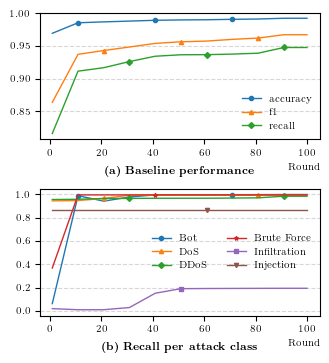

In [49]:
import matplotlib.pyplot as plt
from eiffel.analysis.metrics import dict_avg, load_metric, search_results
from eiffel.analysis.plot import Plotable, scale

label_map = {  # just correct the labels
    "Bot": "Bot",
    "DoS": "DoS",
    "DDoS": "DDoS",
    "Brute Force": "Brute Force",
    "Infilteration": "Infiltration",
    "injection": "Injection",
}


paths = search_results(
    "hyperparams/results/",
    scenario="continuous-100",
    target="untargeted",
    distribution="10-0",
    datasets=".*cicids",
    batch_size=512,
    epochs=".*10x.*",
)

metrics_dict = dict_avg([
    load_metric(
        p,
        dotpath=(
            "global.accuracy",
            "global.f1",
            "global.recall",
            "Bot.recall",
            "DoS.recall",
            "DDoS.recall",
            "Brute Force.recall",
            "Infilteration.recall",  # -> still a typo
            "injection.recall",  # -> no caps
        ),
    )
    for p in paths
])

metrics = scale(
    [Plotable(k, v) for k, v in metrics_dict.items()],
    100,
)
global_metrics = dict(
    [Plotable(n.split(".")[1], p) for n, p in metrics if "global" in n]
)
attacks_metrics = dict(
    [Plotable(n.split(".")[0], p) for n, p in metrics if "global" not in n]
)
attacks_metrics = {label_map[k]: v for k, v in attacks_metrics.items()}

x = range(1, len(next(iter(global_metrics.values()))) + 1)

fig, axs = plt.subplots(2, 1, figsize=figsize(1, 1.1), tight_layout=True)
global_ax, attacks_ax = axs
global_ax.set_title("Baseline performance")
attacks_ax.set_title("Recall per attack class")

for label, data in global_metrics.items():
    global_ax.plot(x, data, label=label)

for label, data in attacks_metrics.items():
    attacks_ax.plot(x, data, label=label)

for i, ax in enumerate(axs.ravel()):
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.set_xlabel("Round", loc="right")
    ax.set_title(r"\textbf{" f"({abc[i]}) {ax.get_title()}" r"}")
    for line, m, e in zip(
        ax.lines, itertools.cycle("o^D*sv+x"), range(1, len(ax.lines) + 1)
    ):
        line.set_marker(m)
        line.set_markevery((e * 10, len(ax.lines) * 10))

global_ax.legend(loc="lower right")
attacks_ax.legend(loc="right", ncol=2)

fig.savefig(SAVEDIR + "baseline.pdf")

### Untargeted attacks

In [14]:
from eiffel.analysis.metrics import choices, display_choices

display_choices(choices("attacks-untargeted/results/"))

Key,Values
datasets,nfv2_sampled_cicids
distribution,"10-0, 9-1, 3-7, 7-3, 5-5"
epochs,100_10x10
scenario,"continuous-60, continuous-90, continuous-100, continuous-10, continuous-30, continuous-80, continuous-99, continuous-70, continuous-95"
target,untargeted
batch_size,512
partitioner,iid
seed,"1977, 1138, 6567, 327, 2187, 501, 3263827, 1313, 421, 5555"


In [15]:
# import re
# from functools import partial

# import matplotlib.pyplot as plt
# import numpy as np
# from eiffel.analysis.metrics import load_asr, search_results
# from eiffel.analysis.plot import Plotable, scale

# searchfn = partial(
#     search_results, "attacks-untargeted/results/", target="untargeted", epochs=".*10x.*"
# )

# fig, axs = plt.subplots(
#     2,
#     2,
#     figsize=figsize(1, 1.3),
#     sharey="row",
#     gridspec_kw={"height_ratios": (1, 1.5)},
#     tight_layout=True,
# )

# for i, dist in enumerate(["9-1", "7-3", "5-5", "3-7"]):
#     i = (i // 2, i % 2)
#     axs[i].set_title(rf"{int(dist.split('-')[-1])*10}\% malicious")

#     seed_re = re.compile(r"seed=(\d+)")
#     refs = [
#         Plotable(m, load_asr(m))
#         for m in searchfn(
#             scenario="continuous-100", distribution="10-0"
#         )  # any scenario will do since there are no malicious clients
#     ]
#     assert len(refs) == 10

#     for scenario in [
#         "continuous-10",
#         "continuous-30",
#         "continuous-60",
#         "continuous-70",
#         "continuous-80",
#         "continuous-90",
#         "continuous-95",
#         "continuous-99",
#         "continuous-100",
#     ]:
#         plotables = []
#         for ref in refs:
#             seed = seed_re.search(ref.name)
#             assert seed, f"Could not find seed in {ref.name}"
#             seed = seed.group(1)
#             m = searchfn(scenario=scenario, distribution=dist, seed=seed)
#             assert len(m) == 1, f"Expected 1 result, got {len(m)}"
#             m = m[0]
#             plotables.append(Plotable(m, load_asr(m, reference=ref.values)))
#         plotables = scale(plotables, 100)
#         data = np.array([p.values for p in plotables])
#         axs[i].plot(
#             data.mean(axis=0), label=f"{scenario.split('-')[-1]}% of poisoned data"
#         )

#     # refs = scale(refs, 100)
#     # benign = np.array([p.values for p in refs])
#     # axs[i].plot(benign.mean(axis=0), label="benign", linestyle="--")

# abc = "abcdefghijklmnopqrstuvwxyz"
# counter = 0
# for ax in axs.ravel():  # top row
#     ax.set_title(r"\textbf{" f"({abc[counter]}) {ax.get_title()}" r"}")
#     counter += 1

# for ax in axs[:, 0]:  # left column
#     ax.set_ylabel("RASR", loc="top")

# for ax in axs.ravel():
#     ax.grid(axis="y", linestyle="--", alpha=0.5)
#     # ax.set_xlabel("Round", loc="right")


# lines, labels = axs.ravel()[0].get_legend_handles_labels()
# lgd = fig.legend(lines, labels, loc="upper center", ncol=5, bbox_to_anchor=(0.5, 1.07))

# fig.savefig(
#     SAVEDIR + "attacks-untargeted.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight"
# )

There is a massive difference between 60% and 100% of poisoned data.
At 60%, even with 50% of attackers, the performance is still very high (>=0.85).
Starting at 80%, we start to see a significant drop in performance, and at >=90%, the performance is very low (<=0.2).
Only with 100% of poisoned data, we see a significant drop in performance with 50% of attackers.

Further, below 80% of poisoned data, and while the participants take time to converge, most participants achieve relatively high results (F1-score).

Plotted the other way around, we see how non-linear the relation between the proportion of poisoned data and the performance is.
At 50% of malicious clients, there is a massive threshold effect between 99% and 100% of poisoned data.

Another interesting aspects is that even with 30% of attackers, and despite keeping high performance, the poisoning impact is still not linear.
The biggest gap is between 99% and 100% of poisoned data, while there almost no difference 70% and 80%.

### Targeted attacks

In [16]:
from eiffel.analysis.metrics import choices, display_choices

display_choices(choices("attacks-targeted/results/"))
display_choices(choices("backdoor/results/"))

attacks-targeted/results/: Not all theoritical combinations are covered: 2700 possibles, 2100 found.


Key,Values
datasets,nfv2_sampled_cicids
distribution,"7-3, 5-5, 3-7, 10-0, 9-1"
epochs,100_10x10
scenario,"continuous-90, continuous-99, continuous-60, continuous-80, continuous-100, continuous-30, continuous-95, continuous-10, continuous-70"
target,"ddos, dos, bot, bruteforce, injection, infiltration"
batch_size,512
partitioner,iid
seed,"5555, 1138, 6567, 421, 3263827, 2187, 1977, 327, 1313, 501"


Key,Values
datasets,nfv2_sampled_cicids
distribution,"3-7, 7-3, 10-0, 5-5, 9-1"
epochs,100_10x10
scenario,"continuous-60, continuous-100, continuous-30"
target,"ddos, dos, bot, bruteforce, injection, infiltration"
batch_size,512
partitioner,iid
seed,"6567, 421, 2187, 327, 1313, 1977, 3263827, 5555, 501, 1138"


In [17]:
# import re
# from functools import partial

# import matplotlib.pyplot as plt
# import numpy as np
# from eiffel.analysis.metrics import load_asr, search_results
# from eiffel.analysis.plot import Plotable, scale

# searchfn = partial(
#     search_results, "attacks-targeted/results/", epochs=".*10x.*", batch_size=512
# )

# fig, axs = plt.subplots(
#     2,
#     2,
#     figsize=figsize(1, 1.3),
#     sharey="row",
#     gridspec_kw={"height_ratios": (1, 1.5)},
#     tight_layout=True,
# )
# seed_re = re.compile(r"seed=(\d+)")

# target_refs = {}
# for cls in ["Bot", "DoS", "DDoS", "Brute Force"]:
#     target_refs[cls] = [
#         Plotable(m, load_asr(m))
#         for m in searchfn(scenario="continuous-100", distribution="10-0", target="bot")
#     ]  # any scenario/target will do since there are no malicious clients
#     assert len(target_refs[cls]) == 10
# benign = np.mean(
#     [np.mean([p.values for p in refs], axis=0) for refs in target_refs.values()], axis=0
# )  # average over all attacks


# for i, dist in enumerate(["9-1", "7-3", "5-5", "3-7"]):
#     i = (i // 2, i % 2)
#     axs[i].set_title(rf"{int(dist.split('-')[-1])*10}\% malicious")

#     for scenario in [
#         "continuous-10",
#         "continuous-30",
#         "continuous-60",
#         "continuous-70",
#         "continuous-80",
#         "continuous-90",
#         "continuous-95",
#         "continuous-99",
#         "continuous-100",
#     ]:
#         # Some attacks are excluded:
#         # - Infiltration: too hard to detect (see baseline)
#         # - Injection: too few samples to be relevant (see dataset stats)
#         targeted = []
#         benign = []
#         for target, cls in [
#             ("bot", "Bot"),
#             ("dos", "DoS"),
#             ("ddos", "DDoS"),
#             ("bruteforce", "Brute Force"),
#         ]:
#             refs: list[Plotable] = target_refs[cls]
#             plotables = []
#             for ref in refs:
#                 seed = seed_re.search(ref.name)
#                 assert seed, f"Could not find seed in {ref.name}"
#                 seed = seed.group(1)
#                 m = searchfn(
#                     scenario=scenario, distribution=dist, seed=seed, target=target
#                 )
#                 assert len(m) == 1, f"Expected 1 result, got {len(m)}"
#                 m = m[0]
#                 plotables.append(
#                     Plotable(m, load_asr(m, target=[cls], reference=ref.values))
#                 )
#             plotables = scale(plotables, 100)
#             data = np.array([p.values for p in plotables])
#             targeted.append(data.mean(axis=0))

#         targeted = np.array(targeted).mean(axis=0)
#         axs[i].plot(targeted, label=f"{scenario.split('-')[-1]}% of poisoned data")
#         # axs[i].plot(benign, label="benign", linestyle="--")

# abc = "abcdefghijklmnopqrstuvwxyz"
# for i, ax in enumerate(axs.ravel()):
#     ax.set_title(r"\textbf{" f"({abc[i]}) {ax.get_title()}" r"}", x=0.45)
#     ax.grid(axis="y", linestyle="--", alpha=0.5)

# for ax in axs[:, 0]:  # left column
#     ax.set_ylabel("ASR", loc="top")


# lines, labels = axs.ravel()[0].get_legend_handles_labels()
# lgd = fig.legend(lines, labels, loc="upper center", ncol=5, bbox_to_anchor=(0.5, 1.07))

# fig.savefig(
#     SAVEDIR + "attacks-untargeted.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight"
# )

The impact of targeted attacks is much more significant than untargeted attacks.
At 70% of malicious clients, the RASR is close to 1, even with 90% of poisoned data.
On the contrary, with untargeted attacks, 90% of poisoned data is not enough as it only reaches a RASR of 0.6.

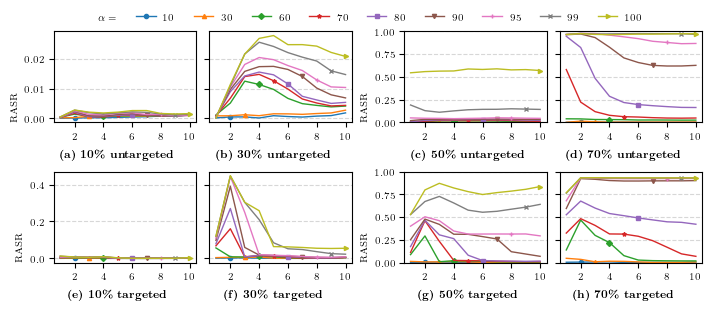

In [158]:
import re
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from eiffel.analysis.metrics import load_asr, search_results
from eiffel.analysis.plot import Plotable
from matplotlib.axes import Axes

searchfn = partial(
    search_results, "attacks-untargeted/results/", target="untargeted", epochs=".*10x.*"
)

fig, axs = plt.subplots(
    2,
    4,
    figsize=figsize(1, 0.4, two_column=True),
    # gridspec_kw={"height_ratios": (1, 1.5)},
    # tight_layout=True,
    constrained_layout=True,
)
seed_re = re.compile(r"seed=(\d+)")


benign_runs = search_results(
    "attacks-targeted/results/",  # untargeted is the same
    scenario="continuous-100",  # any scenario will do since there are no malicious clients
    target="bot",  # same
    distribution="10-0",
)
assert len(benign_runs) == 10

target_refs = {}
for cls in ["Bot", "DoS", "DDoS", "Brute Force"]:
    target_refs[cls] = [
        Plotable(path, load_asr(path, target=[cls])) for path in benign_runs
    ]
    assert len(target_refs[cls]) == 10
untargeted_refs = [Plotable(path, load_asr(path)) for path in benign_runs]
assert len(untargeted_refs) == 10

x = np.arange(1, len(untargeted_refs[0].values) + 1)

for i, dist in enumerate(["9-1", "7-3", "5-5", "3-7"]):
    for scenario in [
        "continuous-10",
        "continuous-30",
        "continuous-60",
        "continuous-70",
        "continuous-80",
        "continuous-90",
        "continuous-95",
        "continuous-99",
        "continuous-100",
    ]:
        ax: Axes = axs[0, i]  # top row -> untargeted attacks
        ax.set_title(rf"{int(dist.split('-')[-1])*10}\% untargeted")
        searchfn = partial(
            search_results,
            "attacks-untargeted/results/",
            target="untargeted",
            distribution=dist,
            scenario=scenario,
        )
        plotables = []
        for ref in untargeted_refs:
            seed = seed_re.search(ref.name)
            assert seed, f"Could not find seed in {ref.name}"
            seed = seed.group(1)
            m = searchfn(seed=seed)
            assert len(m) == 1, f"Expected 1 result, got {len(m)}"
            m = m[0]
            plotables.append(Plotable(m, load_asr(m, reference=ref.values)))
        # plotables = scale(plotables, 100)
        data = np.array([p.values for p in plotables])
        ax.plot(x, data.mean(axis=0), label=rf"{scenario.split('-')[-1]}")

        ax: Axes = axs[1, i]  # second row -> targeted attacks
        ax.set_title(rf"{int(dist.split('-')[-1])*10}\% targeted")
        searchfn = partial(
            search_results,
            "attacks-targeted/results/",
            distribution=dist,
            scenario=scenario,
        )

        # Some attacks are excluded:
        # - Infiltration: too hard to detect (see baseline)
        # - Injection: too few samples to be relevant (see dataset stats)
        targeted = []
        benign = []
        for target, cls in [
            ("bot", "Bot"),
            ("dos", "DoS"),
            ("ddos", "DDoS"),
            ("bruteforce", "Brute Force"),
        ]:
            refs: list[Plotable] = target_refs[cls]
            plotables = []
            for ref in refs:
                seed = seed_re.search(ref.name)
                assert seed, f"Could not find seed in {ref.name}"
                seed = seed.group(1)
                m = searchfn(seed=seed, target=target)
                assert len(m) == 1, f"Expected 1 result, got {len(m)}"
                m = m[0]
                plotables.append(
                    Plotable(m, load_asr(m, target=[cls], reference=ref.values))
                )
            # plotables = scale(plotables, 100)
            data = np.array([p.values for p in plotables])
            targeted.append(data.mean(axis=0))

        targeted = np.array(targeted).mean(axis=0)
        ax.plot(x, targeted, label=rf"{scenario.split('-')[-1]}")


abc = "abcdefghijklmnopqrstuvwxyz"
for (i, j), ax in np.ndenumerate(axs):
    ax.set_title(r"\textbf{" f"({abc[i*4+j]}) {ax.get_title()}" r"}", x=0.45)
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.set_xticks([2, 4, 6, 8, 10])
    for line, m, e in zip(
        ax.lines, itertools.cycle("o^D*sv+x>"), range(1, len(ax.lines) + 1)
    ):
        line.set_marker(m)
        line.set_markevery((e, len(ax.lines)))

    if j in (0, 2):
        ax.set_ylabel("RASR", loc="bottom")
        ax.sharey(axs[i, j + 1])

    if j in (1, 3):
        plt.setp(ax.get_yticklabels(), visible=False)

    if j == 3:
        ax.set_ylim(0, 1)


handles, labels = axs.ravel()[0].get_legend_handles_labels()
handles = [plt.plot([], [], linestyle="")[0]] + handles
labels = [r"$\alpha=$"] + labels


lgd = fig.legend(
    handles, labels, loc="upper center", ncol=10, bbox_to_anchor=(0.5, 1.07)
)

fig.savefig(SAVEDIR + "attacks.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")